# Transit Light Curve Parameter Estimation (Conceptual Plan)

## 1. Scientific Goal

The goal of this analysis is to infer the physical and orbital parameters of an exoplanetary system from transit photometry.  
Given a time series of stellar flux measurements during a planetary transit, we aim to determine which system parameters are consistent with the observed transit shape and depth, and to quantify their uncertainties.

This is achieved using **Bayesian parameter estimation**, combining:
- A physical forward model of transits (`batman`)
- A statistical sampler (`emcee`)

---

## 2. What Information the Transit Light Curve Contains

A transit light curve encodes information about the geometry of the system:

- **Transit depth** → planet-to-star radius ratio \( R_p / R_\star \)
- **Transit duration** → scaled semi-major axis \( a / R_\star \)
- **Ingress and egress shape** → impact parameter \( b \)
- **Transit timing** → mid-transit time \( T_0 \)
- **Repeated transits** → orbital period \( P \)

The light curve alone does **not** determine absolute physical quantities such as the stellar radius or planetary mass.

---

## 3. Role of the `batman` Transit Model

`batman` is used as a **forward model**.

Given a set of physical parameters describing the star–planet system, `batman` computes the expected relative stellar flux as a function of time. It does not fit data or estimate parameters by itself.

In this analysis, `batman` is used to:
- Generate model light curves for proposed parameter values
- Enable direct comparison between model predictions and observed data

---

## 4. Model Parameters

The parameters sampled in the analysis are chosen to reflect the quantities directly constrained by the transit shape:

- \( P \): Orbital period
- \( T_0 \): Mid-transit time
- \( R_p / R_\star \): Planet-to-star radius ratio
- \( a / R_\star \): Scaled semi-major axis
- \( b \): Impact parameter

Derived quantities such as the orbital inclination are computed from these parameters rather than sampled directly.

---

## 5. Statistical Framework

### 5.1 Likelihood Function

For a given set of model parameters, a transit light curve is generated using `batman` and compared to the observed flux data.

Assuming Gaussian, uncorrelated noise, the likelihood quantifies how well the model reproduces the observed data given the measurement uncertainties.

### 5.2 Priors

Priors are used to enforce physical and geometrical constraints, such as:
- Positive planetary radius
- Valid transit geometry
- Reasonable ranges for orbital parameters

These priors prevent the sampler from exploring unphysical regions of parameter space.

---

## 6. Parameter Inference Using MCMC

Markov Chain Monte Carlo (MCMC) sampling is used to explore the posterior probability distribution of the model parameters.

The MCMC algorithm:
1. Proposes a new set of parameters
2. Generates a transit model using `batman`
3. Evaluates how well the model matches the data
4. Accepts or rejects the proposal based on its posterior probability
5. Repeats this process many times

This produces a large collection of samples drawn from the posterior distribution.

---

## 7. Extracting Parameter Estimates

The MCMC output is a set of samples representing plausible system configurations.

For each parameter:
- The median of the posterior distribution is adopted as the best estimate
- The 16th and 84th percentiles define the uncertainty interval

These values represent statistically rigorous parameter estimates informed by both the data and physical constraints.

---

## 8. Interpretation and Physical Insight

From the inferred parameters, additional physical quantities can be derived, including:
- Stellar density (from \( a / R_\star \) and Kepler’s third law)
- Transit duration and ingress/egress times
- Constraints on orbital inclination

These results can later be combined with radial velocity measurements to determine absolute planetary mass and radius.

---

## 9. Summary

- `batman` provides a physical model of the transit light curve
- `emcee` explores which model parameters are consistent with the data
- Parameter estimation is performed by analysing the posterior distributions
- The final results include both best-fit values and uncertainties

This framework provides a statistically robust and physically motivated approach to transit light curve analysis.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import batman
import emcee

In [8]:
"""
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.0694                    #time of inferior conjunction (Midpoint of transit in days)
params.per = 1.4013794                #orbital period
params.rp = 0.1338519                 #planet radius (in units of stellar radii)
params.a = 5.225                      #semi-major axis (in units of stellar radii)
params.inc = 82                       #orbital inclination (in degrees)
params.ecc = 0                        #eccentricity
params.w = 90                         #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.664, -0.378, 0.945, -0.470]      #limb darkening coefficients [u1, u2, u3, u4]
"""

'\nparams = batman.TransitParams()       #object to store transit parameters\nparams.t0 = 0.0694                    #time of inferior conjunction (Midpoint of transit in days)\nparams.per = 1.4013794                #orbital period\nparams.rp = 0.1338519                 #planet radius (in units of stellar radii)\nparams.a = 5.225                      #semi-major axis (in units of stellar radii)\nparams.inc = 82                       #orbital inclination (in degrees)\nparams.ecc = 0                        #eccentricity\nparams.w = 90                         #longitude of periastron (in degrees)\nparams.limb_dark = "nonlinear"        #limb darkening model\nparams.u = [0.664, -0.378, 0.945, -0.470]      #limb darkening coefficients [u1, u2, u3, u4]\n'

In [12]:
# time (days, relative)
t = np.array([
    -6.87055556e-02, -6.80111111e-02, -6.73166667e-02, -6.66222222e-02,
    -6.59277778e-02, -6.52333333e-02, -6.45388889e-02, -6.38444444e-02,
    -6.31500000e-02, -6.24555556e-02, -6.17611111e-02, -6.10666667e-02,
    -6.03722222e-02, -5.96777778e-02, -5.89833333e-02, -5.82888889e-02,
    -5.75944444e-02, -5.69000000e-02, -5.62055556e-02, -5.55111111e-02,
    -5.48166667e-02, -5.41222222e-02, -5.34277778e-02, -5.27333333e-02,
    -5.20388889e-02, -5.13444444e-02, -5.06500000e-02, -4.99555556e-02,
    -4.92611111e-02, -4.85666667e-02, -4.78722222e-02, -4.71777778e-02,
    -4.64833333e-02, -4.57888889e-02, -4.50944444e-02, -4.44000000e-02,
    -4.37055556e-02, -4.30111111e-02, -4.23166667e-02, -4.16222222e-02,
    -4.09277778e-02, -4.02333333e-02, -3.95388889e-02, -3.88444444e-02,
    -3.81500000e-02, -3.74555556e-02, -3.67611111e-02, -3.60666667e-02,
    -3.53722222e-02, -3.46777778e-02, -3.39833333e-02, -3.32888889e-02,
    -3.25944444e-02, -3.19000000e-02, -3.12055556e-02, -3.05111111e-02,
    -2.98166667e-02, -2.91222222e-02, -2.84277778e-02, -2.77333333e-02,
    -2.70388889e-02, -2.63444444e-02, -2.56500000e-02, -2.49555556e-02,
    -2.42611111e-02, -2.35666667e-02, -2.28722222e-02, -2.21777778e-02,
    -2.14833333e-02, -2.07888889e-02, -2.00944444e-02, -1.94000000e-02,
    -1.87055556e-02, -1.80111111e-02, -1.73166667e-02, -1.66222222e-02,
    -1.59277778e-02, -1.52333333e-02, -1.45388889e-02, -1.38444444e-02,
    -1.31500000e-02, -1.24555556e-02, -1.17611111e-02, -1.10666667e-02,
    -1.03722222e-02, -9.67777778e-03, -8.98333333e-03, -8.28888889e-03,
    -7.59444444e-03, -6.90000000e-03, -6.20555556e-03, -5.51111111e-03,
    -4.81666667e-03, -4.12222222e-03, -3.42777778e-03, -2.73333333e-03,
    -2.03888889e-03, -1.34444444e-03, -6.50000000e-04,  4.44444444e-05,
     7.38888889e-04,  1.43333333e-03,  2.12777778e-03,  2.82222222e-03,
     3.51666667e-03,  4.21111111e-03,  4.90555556e-03,  5.60000000e-03,
     6.29444444e-03,  6.98888889e-03,  7.68333333e-03,  8.37777778e-03,
     9.07222222e-03,  9.76666667e-03,  1.04611111e-02,  1.11555556e-02,
     1.18500000e-02,  1.25444444e-02,  1.32388889e-02,  1.39333333e-02,
     1.46277778e-02,  1.53222222e-02,  1.60166667e-02,  1.67111111e-02,
     1.74055556e-02,  1.81000000e-02,  1.87944444e-02,  1.94888889e-02,
     2.01833333e-02,  2.08777778e-02,  2.15722222e-02,  2.22666667e-02,
     2.29611111e-02,  2.36555556e-02,  2.43500000e-02,  2.50444444e-02,
     2.57388889e-02,  2.64333333e-02,  2.71277778e-02,  2.78222222e-02,
     2.85166667e-02,  2.92111111e-02,  2.99055556e-02,  3.06000000e-02,
     3.12944444e-02,  3.19888889e-02,  3.26833333e-02,  3.33777778e-02,
     3.40722222e-02,  3.47666667e-02,  3.54611111e-02,  3.61555556e-02,
     3.68500000e-02,  3.75444444e-02,  3.82388889e-02,  3.89333333e-02,
     3.96277778e-02,  4.03222222e-02,  4.10166667e-02,  4.17111111e-02,
     4.24055556e-02,  4.31000000e-02,  4.37944444e-02,  4.44888889e-02,
     4.51833333e-02,  4.58777778e-02,  4.65722222e-02,  4.72666667e-02,
     4.79611111e-02,  4.86555556e-02,  4.93500000e-02,
], dtype=float)

flux = np.array([
    0.98565958, 0.99294373, 0.99283377, 1.00110954, 0.99552327, 0.99949106,
    0.99848596, 1.00145520, 1.00285730, 1.00595446, 0.99774880, 0.99942303,
    1.00263370, 1.00407008, 1.00264337, 0.99919573, 1.00199523, 0.99432410,
    1.00765569, 0.99834167, 1.00389142, 1.00000000, 0.99977382, 1.00224629,
    1.00026529, 0.99739785, 0.99669758, 0.99441057, 1.00280865, 1.00252988,
    0.98675384, 1.00375521, 0.99373792, 1.00211985, 1.01614583, 1.00722094,
    0.99963354, 0.99528024, 0.99796293, 0.99793371, 1.00530050, 0.99107308,
    1.00247087, 1.01160412, 0.99089096, 0.99016866, 1.01934792, 1.02629287,
    1.02680795, 1.00363327, 0.99734383, 1.00570734, 1.00953893, 1.00410276,
    0.99945755, 0.99969289, 0.99820432, 1.01823947, 0.99850833, 0.98040795,
    0.99509470, 1.00040170, 1.00016283, 0.99530270, 0.99000282, 0.99240342,
    0.98985784, 0.98341506, 0.98909382, 0.98702951, 0.98067519, 0.98434236,
    0.98057561, 0.98077620, 0.98454634, 0.98292108, 0.98329690, 0.98550577,
    0.98289660, 0.98104564, 0.98709135, 0.97618139, 0.97678200, 0.97641691,
    0.97946535, 0.97933727, 0.98138360, 0.98441259, 0.98411459, 0.97693733,
    0.98177496, 0.97954062, 0.97756189, 0.97761290, 0.97902981, 0.98163362,
    0.97677560, 0.97896485, 0.98231251, 0.97747550, 0.98088453, 0.98016232,
    0.98379390, 0.98058080, 0.97953527, 0.97906063, 0.98304494, 0.98259267,
    0.98137292, 0.97995037, 0.98320261, 0.98019567, 0.97203622, 0.98209140,
    0.97804314, 0.98382851, 0.98450880, 0.98155105, 0.98629437, 0.98422774,
    0.98571121, 0.97918831, 0.98104018, 2.19519758, 0.98048009, 0.98445121,
    0.98491926, 0.97934652, 0.98671671, 0.98417909, 0.98501760, 0.98627332,
    0.98974177, 0.98987093, 0.99096602, 0.99488406, 0.99603385, 1.00450302,
    0.99870100, 1.00672300, 0.99468214, 1.00032826, 0.99900843, 1.00074510,
    0.99400903, 0.99018273, 0.99916748, 1.00204695, 0.99794204, 0.99838699,
    0.99674375, 0.99437468, 0.99755854, 0.99796343, 0.99876238, 1.00102638,
    1.00320181, 1.00086334, 1.00836473, 0.99856618, 1.00106983, 0.99021676,
    0.99299954, 0.99611338, 1.00162565, 0.99626099, 0.99553622, 1.00475482,
    1.00002388, 1.01601451, 0.99809844,
], dtype=float)

#drop outlier at ~2.195 
m = flux < 1.5
t, flux = t[m], flux[m]

# estimate uncertainties for the sake of mcmc constant for everything, std of baseline
out_of_transit = np.abs(flux - 1.0) < 0.005 
ferr = np.ones_like(flux) * np.std(flux[out_of_transit])


In [13]:
P_FIXED = 1.4013776  # days (literature)
B_FIXED = 0.8    # fixed impact parameter

def transit_model(t, T0, aRs, RpRs):
    params = batman.TransitParams()
    params.t0 = T0 #transit mid point, lowest flux point basically
    params.per = P_FIXED
    params.rp = RpRs
    params.a = aRs # semi-major axis in stellar radii
    params.inc = np.degrees(np.arccos(B_FIXED / aRs))
    params.ecc = 0.0 # assuming circular keplerian orbit
    params.w = 90.0
    params.u = [0.5]
    params.limb_dark = "linear"
    m = batman.TransitModel(params, t)
    return m.light_curve(params)

# theta = [T0, ln(a/Rs), ln(Rp/Rs)]
def log_probability(theta, t, f, ferr):
    T0, log_aRs, log_RpRs = theta
    aRs, RpRs = np.exp(log_aRs), np.exp(log_RpRs)
    
    # priors
    if not (0 < RpRs < 0.2 and B_FIXED < aRs < 1e3):
        return -np.inf
    if not (t.min() - 0.05 < T0 < t.max() + 0.05):
        return -np.inf
    
    # likelihood
    model = transit_model(t, T0, aRs, RpRs)
    return -0.5 * np.sum(((f - model) / ferr) ** 2)

# MCMC
nwalkers, ndim = 100, 3
T0_guess = t[np.argmin(flux)] #lowest flux is initial guess for mid transit
initial = np.array([T0_guess, np.log(8.0), np.log(np.sqrt(1 - flux.min()))]) # initial guesses for T0, aRs, RpRs
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim) # cloud around initial guess for walkers

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t, flux, ferr))
sampler.run_mcmc(pos, 5000, progress=True)

samples = sampler.get_chain(discard=500, thin=10, flat=True) # burn in step for sampler

# results
T0 = np.median(samples[:, 0])
aRs = np.median(np.exp(samples[:, 1]))
RpRs = np.median(np.exp(samples[:, 2]))

print(f"T0    = {T0:.6f} days")
print(f"a/Rs  = {aRs:.4f}")
print(f"b     = {B_FIXED} (fixed)")
print(f"Rp/Rs = {RpRs:.5f}")
print(f"(Rp/Rs)^2 = {RpRs**2:.5f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:10<00:00, 482.64it/s]

T0    = -0.000047 days
a/Rs  = 5.7053
b     = 0.8 (fixed)
Rp/Rs = 0.14698
(Rp/Rs)^2 = 0.02160


In [14]:
def mcmc_posterior(x):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.nan, np.nan, np.nan
    return np.percentile(x, [16, 50, 84])
    
def duration_T14(P, aRs, b, RpRs):
    """
    First-to-fourth contact duration T14 (days), circular orbit.

    Transit duration formula for a cirular orbit e=0:
      T14 = (P/pi) * asin( sqrt((1+RpRs)^2 - b^2) / (aRs * sin i) )
      with  b = aRs*cos i  => sin i = sqrt(1 - (b/aRs)^2)
    """
    sin_i = np.sqrt(1 - (b / aRs) ** 2)
    arg = np.sqrt((1 + RpRs) ** 2 - b ** 2) / (aRs * sin_i)
    return (P / np.pi) * np.arcsin(arg)

# Compute T14 for each posterior sample
T14_samples = [duration_T14(P_FIXED, a, B_FIXED, r) 
               for a, r in zip(np.exp(samples[:, 1]), np.exp(samples[:, 2]))]

T14_med = np.median(T14_samples)
print(f"T14 = {T14_med:.6f} days = {24*T14_med:.3f} hours")

T14 = 0.065138 days = 1.563 hours


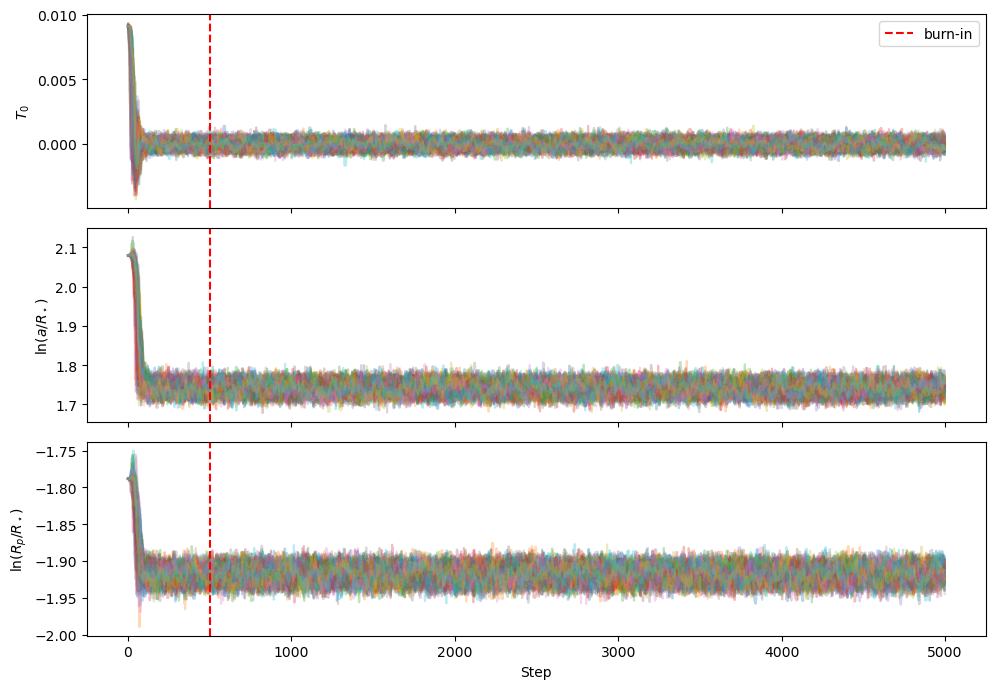

In [15]:
#time series parameter plot / trace plot

chain = sampler.get_chain()  # shape: (nsteps, nwalkers, ndim)
labels = [r"$T_0$", r"$\ln(a/R_\star)$", r"$\ln(R_p/R_\star)$"]

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(chain[:, :, i], alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.axvline(500, color='r', linestyle='--', label='burn-in' if i == 0 else None)
axes[0].legend(loc='upper right')
axes[-1].set_xlabel("Step")
fig.tight_layout()
plt.show()

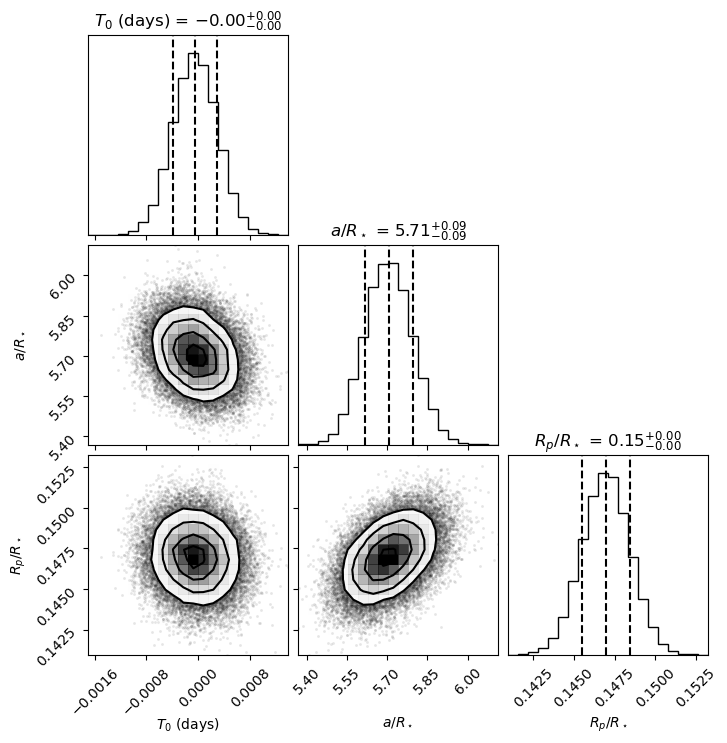

In [ ]:
import corner

# convert to physical units for plotting
plot_samples = np.column_stack([
    samples[:, 0],           # T0
    np.exp(samples[:, 1]),   # a/Rs
    np.exp(samples[:, 2])    # Rp/Rs
])

fig = corner.corner(plot_samples, labels=[r"$T_0$ (days)", r"$a/R_\star$", r"$R_p/R_\star$"],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True)
plt.show()

#discuss covariances between a/Rs and Rp/Rs 

In [ ]:
# results with errors
# we use the 16th, 50th, and 84th percentiles to represent the median and ±1σ uncertainties over just using 
# plain std because it prevents issues with non-symmetric distributions so we are not assuming its gaussian

T0_16, T0_med, T0_84 = mcmc_posterior(samples[:, 0])
aRs_16, aRs_med, aRs_84 = mcmc_posterior(np.exp(samples[:, 1]))
RpRs_16, RpRs_med, RpRs_84 = mcmc_posterior(np.exp(samples[:, 2]))

print(f"T0    = {T0_med:.6f} +{T0_84-T0_med:.6f} -{T0_med-T0_16:.6f} days")
print(f"a/Rs  = {aRs_med:.4f} +{aRs_84-aRs_med:.4f} -{aRs_med-aRs_16:.4f}")
print(f"b     = {B_FIXED} (fixed)")
print(f"Rp/Rs = {RpRs_med:.5f} +{RpRs_84-RpRs_med:.5f} -{RpRs_med-RpRs_16:.5f}")
print(f"(Rp/Rs)^2 = {RpRs_med**2:.5f}")

T14_16, T14_med, T14_84 = mcmc_posterior(T14_samples)
print(f"T14 = {T14_med:.6f} +{T14_84-T14_med:.6f} -{T14_med-T14_16:.6f} days ")


T0    = -0.000047 +0.000340 -0.000340 days
a/Rs  = 5.7053 +0.0896 -0.0883
b     = 0.8 (fixed)
Rp/Rs = 0.14698 +0.00147 -0.00147
(Rp/Rs)^2 = 0.02160
T14 = 0.065138 +0.000984 -0.000978 days 


- need to do with correct f_err to do properly
- do we now use these values as priors for our radial velocity fitting 
- corner plot is kinda useless errors have not been handled correctly
- does transit mid point need to be in the BJD time
- RESIDUALS
- 8 APPERTURES 200MM EACH FOR PUBLISHED LIGHT CURVE - super wasp


for rv modelling ive got the data off a table, and what do i exactly do with it. use these priors to fit it?

radial velocity: semi amplitude, mass

fitting rv data: 4 free parameters 2 in y: amplitude (related to mass) and zeropoint offset (meaningless nuisance parameter)
in x: period from RV from paper, zero point offset again time at which rv curve crosses zero is related to transit time cause pull from planet means rv is perpendicular

compute a chi square and say is eccentricity 0 does it make sense

potential use batman to fit everything use transit for rv